# **Practice 11**
Content:
1. Controllability and observability
2. LQR, pole placement and observers design tasks

In [ ]:
#@title Visualization function and libraries
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.signal import place_poles
import numpy as np

def plot_results(x,y,x_label="T",y_label="X(T)",plot_title="X=F(T)",labels=[],xlim=None, ylim=None):
  plt.grid(color='black', linestyle='--', linewidth=1.0, alpha = 0.7)
  plt.grid(True)

  plt.xlabel(x_label)
  plt.ylabel(y_label)
  plt.title(plot_title)

  if type(y)!=type([]):
    if len(labels)==0:
      plt.plot(x,y,linewidth=2.)
    else:
      for i in range(len(labels)):
        plt.plot(x,y[:,i],linewidth=2.,label=labels[i])
      plt.legend()
  else:
    for i in range(len(y)):
      if len(labels)==0:
        plt.plot(x,y[i])
      else:
        if type(x)!=type([]):
          plt.plot(x,y[i],linewidth=2.,label=labels[i])
        else:
          plt.plot(x[i],y[i],linewidth=2.,label=labels[i])
    if len(labels)!=0:
      plt.legend()
    
    if xlim!=None:
      plt.xlim(xlim)
    if ylim!=None:
      plt.ylim(ylim)

  plt.show()
  return

# **Controllability and observability**
**Controllability**: In order to be able to do whatever we want with the given
dynamic system under control input, the system must be controllable. Controllability matrix $\mathbf{R}$:
$$ \mathbf{R} = \begin{bmatrix} \mathbf{B} & \mathbf{AB} & \mathbf{A}^2\mathbf{B} & ... & \mathbf{A}^{n-1}\mathbf{B}\end{bmatrix}$$ when $n$ is number of system states. So, the system is controllable if the controllability matrix has full row rank (i.e. $\mathbf{rank}(\mathbf{R})=n$)


**Observability**: In order to see what is going on inside the system under observation, the system must be observable. Observability matrix $\mathcal{O}$:
$$ \mathcal{O} = \begin{bmatrix} \mathbf{C}^\top & \mathbf{A}^\top\mathbf{C}^\top & (\mathbf{A}^\top)^2\mathbf{C}^\top & ... & (\mathbf{A}^\top)^{n-1}\mathbf{C}^\top\end{bmatrix}$$ when $n$ is number of system states. So, the system is controllable if the observable matrix has full row rank (i.e. $\mathbf{rank}(\mathbf{\mathcal{O}})=n$)

You can reed more information see [paper](https://www.ece.rutgers.edu/~gajic/psfiles/chap5traCO.pdf)

## **Exercises**
Define the controllability and observability:
1. $
\begin{cases}
\dot {\mathbf{x}} = \begin{bmatrix} 1 & -2 \\ 1 & 0
\end{bmatrix} \mathbf{x} + \begin{bmatrix}1\\0
\end{bmatrix} \mathbf{u} \\
\mathbf{y} = \begin{bmatrix}2 & 0
\end{bmatrix} \mathbf{x}
\end{cases}
$

2. $
\begin{cases}
\dot {\mathbf{x}} = \begin{bmatrix} 1 & 2 \\ 3 & 4
\end{bmatrix} \mathbf{x} + \begin{bmatrix}0\\2
\end{bmatrix} \mathbf{u} \\
\mathbf{y} = \begin{bmatrix}1 & 2
\end{bmatrix} \mathbf{x}
\end{cases}
$

3. $
\begin{cases}
\dot {\mathbf{x}} = \begin{bmatrix} 1 & -2 \\ -3 & -4
\end{bmatrix} \mathbf{x} + \begin{bmatrix}2\\1
\end{bmatrix} \mathbf{u} \\
\mathbf{y} = \begin{bmatrix}1 & 2
\end{bmatrix} \mathbf{x}
\end{cases}
$

# **LQR, pole placement and observers design tasks**

## **Exercise 1**
Consider mass-spring-damper system with parameters $m=1$, $k=10$, $b=2$. In this case, you have only a linear encoder to observe the system state, with measurement error $e_x = 0.05$.

Write a state space model for the system and try to stabilize it. The initial state of the system is: $x = 3$ and $\dot{x} = 1$. Define the $K$ and $L$ matrices by different way.

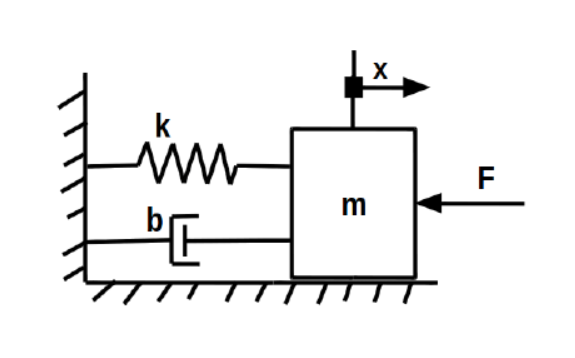


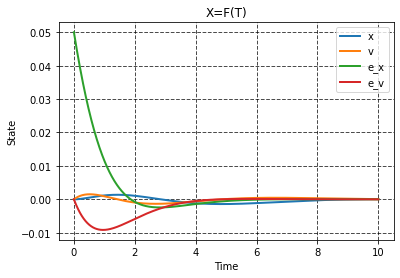

In [ ]:
#Put your code here
import numpy as np 
from scipy.linalg import solve_continuous_are
from scipy.integrate import odeint

k = 1
b = 2
m = 3

A = np.array([[0, 1],
              [-k/m, -b/m]])
B = np.array([[0],
              [1 / m]])
C = np.array([[1, 0]])

def lqr(A, B, Q=None, R=None):
  if Q is None:
    Q = np.eye(A.shape[1])
  if R is None:
    R = np.eye(B.shape[1])
  S = solve_continuous_are(A, B, Q, R)

  return np.linalg.inv(R) @ B.transpose() @ S

K = lqr(A, B)
L = lqr(A.transpose(), C.transpose()).transpose()

AA = np.vstack([
                np.hstack([A - B @ K, B @ K]),
                np.hstack([np.zeros(A.shape), A - L @ C])
])

x0 = np.array([0,
               0,
               0.05,
               0])

t = np.linspace(0, 10, 1000)

def system(xi, ti):
  x_next = AA @ xi.reshape(xi.size, 1)
  return x_next.reshape(x_next.size)


sol = odeint(system, x0, t)

plot_results(t, sol, x_label='Time',
             y_label='State', labels=['x', 'v', 'e_x', 'e_v'])

> **NOTE:** Dynamics for system with observers should be following:
> \begin{equation}
\begin{cases}
\dot {\mathbf{x}} = \mathbf{A} \mathbf{x} + \mathbf{B} \mathbf{u} \\
\hat{\dot {\mathbf{x}}} = \mathbf{A} \hat{\mathbf{x}} + \mathbf{B} \mathbf u + \mathbf{L}(\mathbf y - \mathbf{C} \hat{\mathbf{x}})\\
\mathbf{y} = \mathbf{C} \mathbf{x} \\
\mathbf{u} = -\mathbf{K} (\hat{\mathbf{x}} - \mathbf{x}^*(t)) + \mathbf{u}^*(t)
\end{cases}
\end{equation}
> where $\mathbf{A} - \mathbf{B} \mathbf{K} < 0$ and $\mathbf{A}^{\top} - 
\mathbf{C}^{\top} \mathbf{L}^{\top} < 0$.
This system of equations can be rewritten into the matrix form:
> \begin{equation}
\begin{bmatrix}
\dot {\mathbf{x}} \\
\dot{\mathbf{e}}
\end{bmatrix}
=
\begin{bmatrix}
(\mathbf{A}-\mathbf{B}\mathbf{K}) & \mathbf{B}\mathbf{K} \\
0 & (\mathbf{A}  - \mathbf{L}\mathbf{C})
\end{bmatrix}
\begin{bmatrix}
\mathbf{x} \\
\mathbf{e}
\end{bmatrix}
\end{equation}
This work by the following way:

Let us use the following substitution: $\mathbf{e} = \mathbf{x} - \hat{\mathbf{x}}$, which implies $\hat{\mathbf{x}} = \mathbf{x} - \mathbf{e}$:

Our system had form:

\begin{equation}
\begin{cases}
\dot {\mathbf{x}} = \mathbf{A} \mathbf{x} - \mathbf{B}\mathbf{K} \hat{\mathbf{x}} \\
\hat{\dot {\mathbf{x}}} = \mathbf{A} \hat{\mathbf{x}} - \mathbf{B}\mathbf{K} \hat{\mathbf{x}} + \mathbf{L}(\mathbf{C} \mathbf{x} - \mathbf{C} \hat{\mathbf{x}})
\end{cases}
\end{equation}

Since $\dot{\mathbf{e}} = \dot{\mathbf{x}} - \hat{\dot{\mathbf{x}}}$, we get:
$$
\dot{\mathbf{e}} = 
\mathbf{A} \mathbf{x} - \mathbf{B}\mathbf{K} \hat{\mathbf{x}} - 
(\mathbf{A} \hat{\mathbf{x}} - \mathbf{B}\mathbf{K} \hat{\mathbf{x}} + \mathbf{L}(\mathbf{C} \mathbf{x} - \mathbf{C} \hat{\mathbf{x}}))
$$
$$
\dot{\mathbf{e}} = 
\mathbf{A} (\mathbf{x} - \hat{\mathbf{x}})  - \mathbf{L}\mathbf{C}(\mathbf{x} - \hat{\mathbf{x}})
$$

$$
\dot{\mathbf{e}} = 
(\mathbf{A}  - \mathbf{L}\mathbf{C})\mathbf{e}
$$

Equation for $\dot {\mathbf{x}}$ takes form:

$$
\dot {\mathbf{x}} = (\mathbf{A}-\mathbf{B}\mathbf{K}) \mathbf{x} +  \mathbf{B}\mathbf{K}\mathbf{e}
$$

In matrix form this equations is:
\begin{equation}
\begin{bmatrix}
\dot {\mathbf{x}} \\
\dot{\mathbf{e}}
\end{bmatrix}
=
\begin{bmatrix}
(\mathbf{A}-\mathbf{B}\mathbf{K}) & \mathbf{B}\mathbf{K} \\
0 & (\mathbf{A}  - \mathbf{L}\mathbf{C})
\end{bmatrix}
\begin{bmatrix}
\mathbf{x} \\
\mathbf{e}
\end{bmatrix}
\end{equation}

## **Exercise 2**
Try to stabilize mass-spring-dempher system on the $x_d=3$. The conditions will be the same.

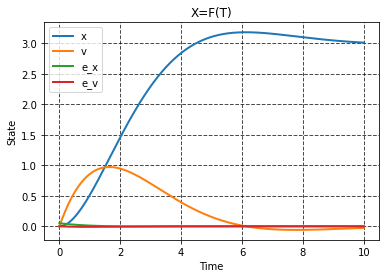

In [ ]:
#Put your code here
import numpy as np 
from scipy.linalg import solve_continuous_are, pinv
from scipy.integrate import odeint

k = 1
b = 2
m = 3

x_d =  3
x_d = np.array([[x_d], [0]])

A = np.array([[0, 1],
              [-k/m, -b/m]])
B = np.array([[0],
              [1 / m]])
C = np.array([[1, 0]])

def lqr(A, B, Q=None, R=None):
  if Q is None:
    Q = np.eye(A.shape[1])
  if R is None:
    R = np.eye(B.shape[1])
  S = solve_continuous_are(A, B, Q, R)

  return np.linalg.inv(R) @ B.transpose() @ S

K = lqr(A, B)
L = lqr(A.transpose(), C.transpose()).transpose()

AA = np.vstack([
                np.hstack([A - B @ K, B @ K]),
                np.hstack([np.zeros(A.shape), A - L @ C])
])

u_d = pinv(B) @ (-A @ x_d)

BB = np.vstack([B @ K @ x_d + B @ u_d, 
                np.zeros(B.shape)])

x0 = np.array([0,
               0,
               0.05,
               0])

t = np.linspace(0, 10, 1000)

def system(xi, ti):
  x_next = AA @ xi.reshape(xi.size, 1) + BB
  return x_next.reshape(x_next.size)


sol = odeint(system, x0, t)

plot_results(t, sol, x_label='Time',
             y_label='State', labels=['x', 'v', 'e_x', 'e_v'])

## **Exercise 3**
Try to stabilize the mass-spring-dempher system near the trajectory $x_d=sin(wt)$, when $w=4$

In [ ]:
#Put your code here
